## Optimization
### Kirill Zakharov
#### 01.03.2021

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline
plt.style.use('ggplot')

In [2]:
passengers = pd.read_csv('ausair.csv', index_col='Year', parse_dates=True)
passengers.head()

,Passengers
Year,
1970-01-01,7.32
1971-01-01,7.33
1972-01-01,7.80
1973-01-01,9.38
1974-01-01,10.66


In [3]:
num = passengers.values
date1 = passengers.index[-1] + pd.DateOffset(years=1)
date2 = date1 + pd.DateOffset(years=9)
dates = pd.date_range(date1, date2, freq='YS')
dates

DatetimeIndex(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01',
               '2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01',
               '2025-01-01', '2026-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [4]:
def forecast_H2_opt(alpha, beta):
    df = num[:, 0]
    h = 10
    res = [df[0]]
    l, b = df[0], df[1] - df[0]
    sum1 = 0
    
    for t in range(1, len(df)):
        prev_l, l = l, alpha*df[t] + (1-alpha)*(l + b)
        b = beta*(l-prev_l) + (1-beta)*b
        res.append(l + b)
    
    forecast = res
    for t in range(len(df), len(df)+h):
        prev_l, l = l, alpha*forecast[t-1] + (1-alpha)*(l + b)
        b = beta*(l-prev_l) + (1-beta)*b
        forecast.append(l + b)
        
    for t in range(1, len(df)):
        sum1 += (df[t]-res[t-1])**2
    
    return sum1/(len(df)-1)

In [5]:
opt = minimize(lambda x: forecast_H2_opt(x[0], x[1]), (0, 0), bounds=((0, 1), (0, 1)))
opt

      fun: 4.083660456834512
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.99360578e-07, -8.88178420e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 54
      nit: 17
   status: 0
  success: True
        x: array([0.85085928, 0.12919859])

In [6]:
def forecast_H2(df, alpha, beta, h):
    res = [df[0]]
    l, b = df[0], df[1] - df[0]
    for t in range(1, len(df)):
        prev_l, l = l, alpha*df[t] + (1-alpha)*(l + b)
        b = beta*(l-prev_l) + (1-beta)*b
        res.append(l + b)
    
    forecast = res
    for t in range(len(df), len(df)+h):
        prev_l, l = l, alpha*forecast[t-1] + (1-alpha)*(l + b)
        b = beta*(l-prev_l) + (1-beta)*b
        forecast.append(l + b)
        
    return forecast[:-h], forecast[-h:]

In [7]:
alpha = opt.x[0]
beta = opt.x[1]
h = 10

forecast2 = pd.DataFrame(dates)
forecast2.columns = ['Year']
forecast2 = forecast2.set_index('Year')
smooth, forecast2['Passengers'] = forecast_H2(num[:, 0], alpha, beta, h)

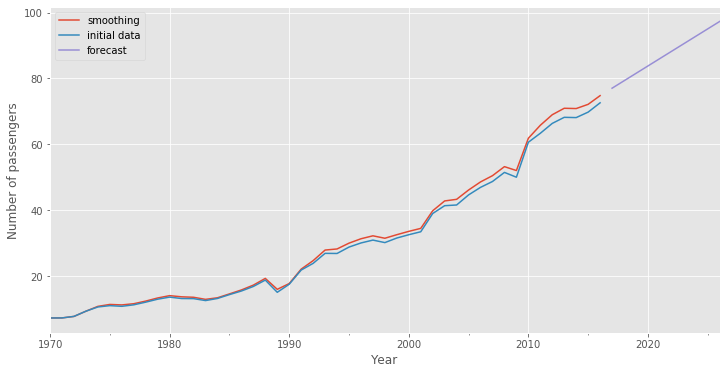

In [8]:
d = pd.DataFrame(pd.date_range('1970-01-01', '2016-01-01', freq='YS'))
d.columns = ['Year']
d = d.set_index('Year')

d['Passengers'] = smooth
d['Passengers'].plot(label='smoothing', figsize=(12, 6))

passengers['Passengers'].plot(figsize=(12, 6), label='initial data')
forecast2['Passengers'].plot(label='forecast')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

In [9]:
def add_trend_opt(alpha, beta, phi):
    df = num[:, 0]
    h = 10
    res = [df[0]]
    l, b = df[0], df[1] - df[0]
    sum1 = 0
        
    for t in range(1, len(df)):
        prev_l, l = l, alpha*df[t] + (1-alpha)*(l + phi*b)
        b = beta*(l-prev_l) + (1-beta)*phi*b
        res.append(l + phi*b)
    
    forecast = res
    for t in range(len(df), len(df)+h):
        prev_l, l = l, alpha*forecast[t-1] + (1-alpha)*(l+phi*b)
        b = beta*(l-prev_l) + (1-beta)*phi*b
        forecast.append(l + phi*b)
        
    for t in range(1, len(df)):
        sum1 += (df[t]-res[t-1])**2    
        
    return sum1/(len(df)-1)

In [10]:
opt1 = minimize(lambda x: add_trend_opt(x[0], x[1], x[2]), (0, 0, 1), bounds=((0, 1), (0, 1), (0, 1)))
opt1

      fun: 4.083660456834664
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.66453526e-07, -4.26325641e-06, -5.01507555e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 76
      nit: 17
   status: 0
  success: True
        x: array([0.8508595 , 0.12919849, 1.        ])

In [11]:
def add_trend(df, alpha, beta, phi, h):
    res = [df[0]]
    l, b = df[0], df[1] - df[0]
        
    for t in range(1, len(df)):
        prev_l, l = l, alpha*df[t] + (1-alpha)*(l + phi*b)
        b = beta*(l-prev_l) + (1-beta)*phi*b
        res.append(l + phi*b)
    
    forecast = res
    for t in range(len(df), len(df)+h):
        prev_l, l = l, alpha*forecast[t-1] + (1-alpha)*(l+phi*b)
        b = beta*(l-prev_l) + (1-beta)*phi*b
        forecast.append(l + phi*b)
        
    return forecast[:-h], forecast[-h:]

In [12]:
num = passengers.values
alpha = opt1.x[0]
beta = opt1.x[1]
phi = 0.9
h = 10

forecast3 = pd.DataFrame(dates)
forecast3.columns = ['Year']
forecast3 = forecast3.set_index('Year')
smooth, forecast3['Passengers'] = add_trend(num[:, 0], alpha, beta, phi, h)

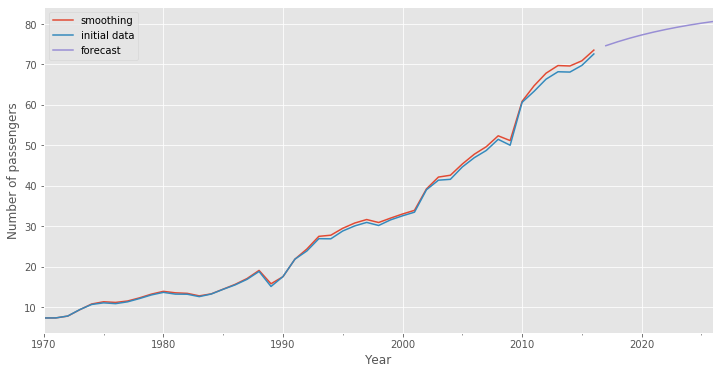

In [13]:
d = pd.DataFrame(pd.date_range('1970-01-01', '2016-01-01', freq='YS'))
d.columns = ['Year']
d = d.set_index('Year')

d['Passengers'] = smooth
d['Passengers'].plot(label='smoothing', figsize=(12, 6))

passengers['Passengers'].plot(figsize=(12, 6), label='initial data')
forecast3['Passengers'].plot(label='forecast')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()